# Tutorial 3 - End-to-end training for computer vision Solutions

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

After a quick recap on Stochastic Gradient Descent in tutorial 1, tutorial 2 showed through two very simple regression examples how using an automated differentiator such as Tensorflow made coding more seamless.

We wrote down how to compute our expected loss (going back to the principle of rationality that we started the class with) and attempted to minimize it by correcting errors as we notice them.

Using an automated differentiator for linear or logistic regression problems is a bit of an overkill, but now we are going to use this tool up for its full potential with complex classification problems.

# Classifying images

Image classification is one of the most challenging tasks machine learning engineers attempt to achieve. Lately, the use of deep convolutional networks have achieved a significant breakthrough in the field.

https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks

We are going to focus on a less challenging task and will attempt to classify hand written digits in this tutorial using the MNIST dataset.

http://yann.lecun.com/exdb/mnist/

## The data

Let's load the dataset (this may take a few minutes).

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=False)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


and let's look at some examples.

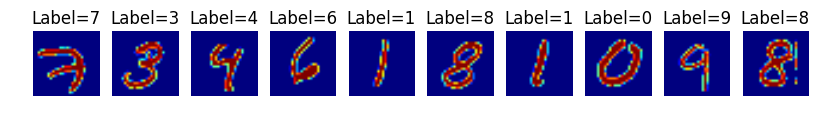

In [3]:
examples_to_show = 10
f, a = plt.subplots(1, examples_to_show, figsize=(10, 2))

for i in range(examples_to_show):
    a[i].imshow(np.reshape(mnist.train.images[i], (28, 28)))
    a[i].set_title('Label=%d' % mnist.train.labels[i])
    a[i].axis('off')

## Making room for the data

The mnist images are (28 x 28 x 1) in size, but represented as a flat vector, let's prepare a placeholder for that.

Let's also prepare a placeholder for the label.

In [4]:
## Create a placeholder for the variable X
#
#    Your code here
#

#
#    Solution
#
X = tf.placeholder(dtype=tf.float32, shape=[None, 784])

## Create a placeholder for the variable Y
#
#    Your code here
#

#
#    Solution
#
Y = tf.placeholder(dtype=tf.int32, shape=[None])

### Reshaping the images

We want to transform X from a collection of vectors to a collection of black and white images. Such an image has a shape (28, 28, 1), using the reshape operator, change the shape of X accordingly.

https://www.tensorflow.org/api_docs/python/tf/reshape

In [5]:
#
#    Your code here
#

#
#    Solution
#
X_IMAGE = tf.reshape(X, shape=(-1, 28, 28, 1))

### Preparing a convolution filter

Let's create 32 filters of size (4, 4) that we will apply to the image.

In [6]:
FIRST_FILTERS = tf.Variable(tf.truncated_normal([5, 5, 1, 32]))

We now apply the filters to the image.

https://www.tensorflow.org/api_docs/python/tf/nn/conv2d

In [7]:
X_CONVED = tf.nn.conv2d(X_IMAGE,
                        FIRST_FILTERS,
                        strides=[1, 1, 1, 1],
                        padding='SAME')

Now let's apply a non-linear activation to this filter bank. We choose the linear rectified activation which has the advantage of preventing exploding or vanishing gradients in the back-propagation.

https://www.tensorflow.org/api_docs/python/tf/nn/relu

In [8]:
FIRST_BIASES = tf.Variable(tf.truncated_normal([32]))
                           
FIRST_ACTIVATIONS = tf.nn.relu(X_CONVED + FIRST_BIASES)

Finally, to coalesce the activations, we use a max pooling layer.

https://www.tensorflow.org/api_docs/python/tf/nn/max_pool

In [9]:
OUTPUT_LAYER_1 = tf.nn.max_pool(FIRST_ACTIVATIONS, 
                                ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1],
                                padding='SAME')

We just transformed a shallow (only one channel) but wide image into a representation that is more compact but richer as it features many more channels (16).

In [10]:
print('Shape of input = ', X.get_shape())
print('Shape of output = ', OUTPUT_LAYER_1.get_shape())

('Shape of input = ', TensorShape([Dimension(None), Dimension(784)]))
('Shape of output = ', TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(32)]))


### YOUR ANSWER HERE

Repeat the same operation with the same choice of strides and pooling size but with filter banks of size 64.

In [11]:
#
# Your code here
#

#FILTERS_2 =

#BIASES_2 = 

#ACTIVATIONS_2 = 

#OUTPUT_LAYER_2 = 

#
# Solution
#
FILTERS_2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64]))
BIASES_2 = tf.Variable(tf.truncated_normal([64]))
ACTIVATIONS_2 = tf.nn.relu(tf.nn.conv2d(OUTPUT_LAYER_1, 
                                        FILTERS_2, 
                                        strides=[1, 1, 1, 1],
                                        padding='SAME')
                           + BIASES_2)

OUTPUT_LAYER_2 = tf.nn.max_pool(ACTIVATIONS_2, 
                                ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1],
                                padding='SAME')

print(OUTPUT_LAYER_2.get_shape())

(?, 7, 7, 64)


### Fully connected layer:

The transformations we were using so far were very structured (convolutions). We can in fact multiply the output of a layer by a matrix which is called a fully connected layer.

The first step is to reshape the output of the third layer so as to flatten it.

In [12]:
OUTPUT_LAYER_2 = tf.reshape(OUTPUT_LAYER_2, (-1, 3136))

W = tf.Variable(tf.truncated_normal([3136, 1024]))
BIAS = tf.Variable(tf.truncated_normal([1024]))

OUTPUT_LAYER_3 = tf.nn.relu(tf.matmul(OUTPUT_LAYER_2, W) + BIAS)

This layer has a lot of parameters, to prevent overfitting we use a regularization technique called dropout which randomly reactivates activations.

In [13]:
DROPOUT_RATE = tf.placeholder(dtype=tf.float32, shape=[])
OUTPUT_LAYER_3 = tf.nn.dropout(OUTPUT_LAYER_3, 1.0 - DROPOUT_RATE)

### Logistic regression

Now, create a logit unit that translates an input of dimension 1024 into 10 different intensities corresponding to 10 labels.
As this layer involves a full unstructured matrix multiplication it is often called a fully connected layer.
This layer involves a large number of parameters compared to convolution layers and therefore they are used parsimoniously.
Feel free to add a non linearity at the end of this layer and add another fully connected layer on top if you want to change the architecture of this neural network.

In [14]:
#
# Your code here
#

#
# Solution
#
A = tf.Variable(tf.truncated_normal([1024, 10]))
B = tf.Variable(tf.truncated_normal([10]))

LOGIT = tf.matmul(OUTPUT_LAYER_3, A) + B

Instantiate the corresponding loss and accuracy functions

In [15]:
LOSS = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=LOGIT))
ACCURACY = tf.reduce_mean(tf.cast(tf.nn.in_top_k(LOGIT, Y, 1), tf.float32))

# Optimizers

A particular perk of modern automated differientators is that they make different optimization algorithm available for us.

For now, let's use a stochatic gradient descent routine with a varying step size.

https://www.tensorflow.org/versions/r0.11/api_docs/python/train/decaying_the_learning_rate
https://www.tensorflow.org/versions/master/api_docs/python/train/decaying_the_learning_rate#inverse_time_decay

In [ ]:
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-3
learning_rate = tf.train.inverse_time_decay(starter_learning_rate, 
                                            global_step,
                                            1, 1e-5)
# Passing global_step to minimize() will increment it at each step.
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(LOSS, global_step=global_step)

Now, each time we run the optimizer, the stochastic gradient descent update for the variables is automatically computed.

We iterate multiple times over the data set, once we have seen the entire dataset, an epoch has elapsed. This will be a bit slow over most machines which (like my laptop) do not have a GPU.

Here we do not have a very optimize neural network, however, it is now very easy to play with the number of convolution filters, add a fully connected layer etc to improve the results.

In [ ]:
n_train = mnist.train.num_examples
n_test = mnist.test.num_examples
batch_size = 32
n_epochs = 100

sess = tf.Session()
sess.run(tf.initialize_all_variables())

for epoch in range(n_epochs):
    for step in range(n_train // batch_size):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={X: batch_x, Y: batch_y, DROPOUT_RATE:0.8})
    x_train, y_train = mnist.train.next_batch(n_train)[:n_test]
    train_loss, train_accuracy = sess.run((LOSS, ACCURACY), 
                                          feed_dict={X: x_train, Y: y_train, DROPOUT_RATE:0.0})
    x_test, y_test = mnist.test.next_batch(n_test)
    test_loss, test_accuracy = sess.run((LOSS, ACCURACY), 
                                        feed_dict={X: x_test, Y: y_test, DROPOUT_RATE:0.0})
    
    print('Epoch %d, train_acc=%.2f, test_acc=%.2f' % (epoch, train_accuracy, test_accuracy))

# Going further

Change the optimizer to an adaptive learning rate optimizer such as RMSProp or ADAM. They greatly help with problems that are ill-conditioned (where the slope of the gradient for one parameter is much bigger than for another).

https://www.tensorflow.org/api_guides/python/train

Experiment with gradient clipping and batch normalization to prevent numerical issues and accelerate training.

Visualize your training process and your graph of tensors with tensorboard.